In [53]:
import numpy as np
import pandas as pd
import cvxpy as cp
from geopy import distance

In [72]:
data = pd.read_csv('../Dataset/fri26_d.txt',delim_whitespace=True,header=None).to_numpy()

In [89]:
points = [(-12.059296, -76.975893),
          (-12.079575, -77.009686),
          (-12.087303, -76.996620),
          (-12.084391, -76.975651),
          (-12.063603, -76.960483),
          (-12.056762, -77.014452),
          (-12.011531, -77.002383)]

################################################
# Building distance matrix
################################################
n = len(points)
C = np.zeros((n,n))

for i in range(0, n):
    for j in range(0, len(points)):
        C[i,j] = distance.distance(points[i], points[j]).km

# Showing distance matrix
print('Distance Matrix is:\n')
print(np.round(C,4))

Distance Matrix is:

[[0.     4.3092 3.8329 2.7762 1.7441 4.2076 6.0199]
 [4.3092 0.     1.6596 3.7435 5.6408 2.5764 7.5691]
 [3.8329 1.6596 0.     2.3055 4.7278 3.8966 8.4056]
 [2.7762 3.7435 2.3055 0.     2.8311 5.2142 8.5694]
 [1.7441 5.6408 4.7278 2.8311 0.     5.9246 7.3483]
 [4.2076 2.5764 3.8966 5.2142 5.9246 0.     5.1733]
 [6.0199 7.5691 8.4056 8.5694 7.3483 5.1733 0.    ]]


In [96]:
# Generate a random SDP.
n = 26
np.random.seed(1)
C = data
e = np.ones((n,1))
I = np.eye(n)
J = np.ones((n,n))
constant =  2-2*np.cos((2*np.pi)/n)
# Define and solve the CVXPY problem.
# Create a symmetric matrix variable.
X = cp.Variable((n,n), symmetric=True)
# The operator >> denotes matrix inequality.
constraints = [
    X[i][i] == 0 for i in range(n)
]
constraints += [
    X@e == 2*e
]
constraints += [
    X[i][j] >= 0 for i in range(n) for j in range(n)
]
constraints += [
    X[i][j] <= 1 for i in range(n) for j in range(n)
]
constraints += [
    2*I-X+J-(constant*I) >> 0
]
prob = cp.Problem(cp.Minimize(1/2*cp.trace(C @ X)),
                  constraints)
prob.solve()

# Print result.
print("The optimal value is", prob.value)
print("A solution X is")
print(X.value)


The optimal value is 885.3325366789334
A solution X is
[[-2.96518793e-09  9.99998687e-01  4.57340168e-01 -1.34117817e-06
   7.30617295e-08 -1.71954033e-06 -3.46258082e-07 -1.16892822e-06
  -1.05208871e-06 -1.84093610e-06 -1.48012649e-06 -7.61151033e-07
  -8.85030084e-07 -1.23023533e-06  4.38738168e-01 -1.48132973e-06
   3.01115153e-07 -7.76290451e-07 -7.79109490e-07 -7.30107937e-07
  -2.65922353e-06 -9.27450683e-07 -1.95268140e-06 -1.76173354e-06
   1.03945929e-01 -4.18575012e-07]
 [ 9.99998687e-01 -1.91208489e-10  1.00000028e+00 -4.73677561e-07
   9.44305424e-07 -8.74089569e-07  6.73306859e-07 -8.97069020e-08
  -3.80183111e-08 -8.63096215e-07 -6.29810165e-07  8.89268356e-08
  -3.04560384e-08 -2.35274392e-07 -3.27972998e-08 -2.71752488e-07
   1.61751253e-06  5.29499589e-07  4.70274136e-07  5.50014443e-07
  -1.26391777e-06  4.88274264e-07 -4.98108029e-07 -3.25140160e-07
   3.08581791e-07  9.86473590e-07]
 [ 4.57340168e-01  1.00000028e+00  1.51019505e-09  5.44340004e-03
   1.24117874e-06

In [97]:
################################################
# Solving the integer programming problem
################################################

# Defining variables
X = cp.Variable(C.shape, boolean=True)
u = cp.Variable(n, integer=True)
ones = np.ones((n,1))

# Defining the objective function
objective = cp.Minimize(cp.sum(cp.multiply(C, X)))

# Defining the constraints
constraints = []
constraints += [X @ ones == ones]
constraints += [X.T @ ones == ones]
constraints += [cp.diag(X) == 0]
constraints += [u[1:] >= 2]
constraints += [u[1:] <= n]
constraints += [u[0] == 1]

for i in range(1, n):
    for j in range(1, n):
        if i != j:
            constraints += [ u[i] - u[j] + 1  <= (n - 1) * (1 - X[i, j]) ]

# Solving the problem
prob = cp.Problem(objective, constraints)
prob.solve(verbose=False)

# Transforming the solution to a path
X_sol = np.argwhere(X.value==1)
orden = X_sol[0].tolist()

for i in range(1, n):
    row = orden[-1]
    orden.append(X_sol[row,1])

# Showing the optimal path
print('The path is:\n')
print( ' => '.join(map(str, orden)))

IndexError: index 20 is out of bounds for axis 0 with size 19

In [99]:
Res = X.value
out = [[1 if X.value[i][j]>0.3 else 0 for i in range(X.shape[0])]for j in range(X.shape[1])]

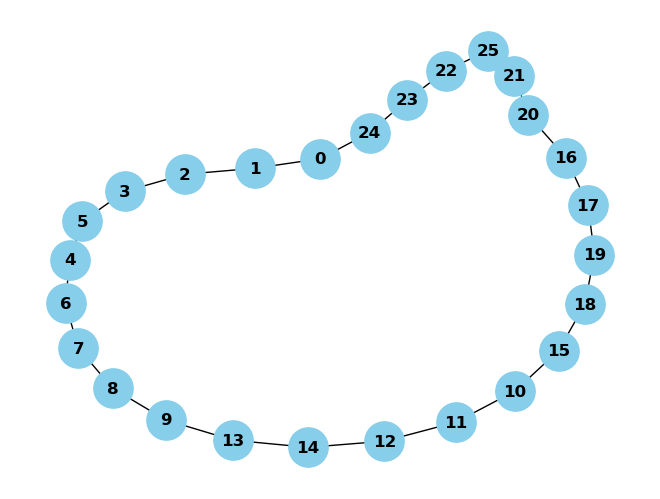

In [100]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define the adjacency matrix
adj_matrix = np.array([
    [0, 1, 1, 0, 0],
    [1, 0, 1, 0, 0],
    [1, 1, 0, 1, 0],
    [0, 0, 1, 0, 1],
    [0, 0, 0, 1, 0]
])

# Create a graph from the adjacency matrix
G = nx.from_numpy_matrix(np.array(out))

# Create a layout for the graph (optional)
pos = nx.spring_layout(G, seed=42)

# Draw the graph with labels
nx.draw(G, pos, with_labels=True, node_color='skyblue', font_weight='bold', node_size=800)

# Show the graph
plt.show()
